<a href="https://colab.research.google.com/github/zapata-git/Evaluacion-de-seguros-de-vida-para-Prudential-/blob/main/03_Modelos_Supervisados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ProyectoIA_Seguros_Prudential**
*Este conjunto de datos contiene información sobre solicitantes de seguros para la compañía Prudential. Se busca crear un algoritmo que perfile solicitantes en una escala de 8 niveles.*

*El conjunto de datos proporcionado contiene variables que describen los atributos de los solicitantes de seguros de vida. La tarea consiste en predecir la variable "Response" para cada ID en el conjunto de prueba. "Response" es una medida ordinal de riesgo que tiene 8 niveles.*

---




#Preparación de datos.
Importamos las bibliotecas necesarias y cargamos el conjunto de datos:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
#Algunas advertencias que queremos evitar
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [2]:
#Para estimar accuracies a partir de métodos de SciKit-Learn en el modelo basado en redes neuronales que usa Tensorflow con Keras
!pip install scikeras --quiet

#Instalación de Jovian y Kaggle mediante pip

* El paquete jovian se utiliza para guardar y compartir proyectos de ciencia de datos en línea.

* El paquete kaggle proporciona una API de línea de comandos para interactuar con Kaggle, una plataforma en línea para competiciones de ciencia de datos y conjuntos de datos.

In [3]:
!pip install jovian --upgrade --quiet
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import jovian

In [4]:
#PARA EJECUTAR ESTA LÍNEA, EN EL COMPUTADOR QUE SE EJECUTE DEBE HABER UNA COPIA DEL JSON WEB TOKEN
#DESCARGABLE DESDE LA PÁGINA DE UNA CUENTA DE KAGGLE EN https://www.kaggle.com/settings/account?...
#ESTE JSON WEB TOKEN ES PERSONAL DE CADA CUENTA Y SIRVE COMO IDENTIFICADOR DE ACCESO.
#CARGUE EL JSON QUE USTED DESCARGÓ DE SU CUENTA DE KAGGLE
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"carlosozapata","key":"1ea90523afd866a234b17caeb4677869"}'}

#Extracción de los archivos del conjunto de datos descargados desde Kaggle

* El conjunto de datos descargado ya contiene separados los datos de train y de test.

* Los archivos quedan almacenados en el entorno de ejecución de Google Colab siempre y cuando se haya autorizado el acceso de la cuenta de Google a este. Esto se debió realizar en bloques de código anteriores.

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
#Para descargar el conjunto de datos desde Kaggle al drive local de Google
!kaggle competitions download 'prudential-life-insurance-assessment'

  0% 0.00/3.24M [00:00<?, ?B/s]
100% 3.24M/3.24M [00:00<00:00, 167MB/s]


In [ ]:
#Para descomprimir los archivos .zip que haya y guardarlos en el entorno de ejecución
import os
from zipfile import ZipFile 
  
#Se indica el nombre del archivo  traído desde Kaggle
file = "prudential-life-insurance-assessment.zip"
  
#Se abre el archivo en modo lectura
with ZipFile(file, 'r') as zip:
  
    #Se extraen todos los archivos
    print('Extracción de archivos en proceso...') 
    zip.extractall() 
    print('Extracción terminada')

%cd "/content/"

for archivo in os.listdir():
  if archivo.endswith(".zip"):
    with ZipFile(archivo, 'r') as zip_ref:
      zip_ref.extractall("/content/")



Extracción de archivos en proceso...
Extracción terminada
/content


In [ ]:
#Se declara el conjunto de datos
datos = pd.read_csv("/content/train.csv")

#Preprocesado.

Se llenan los valores faltantes con la moda si se trata de variables categóricas y la mediana si se trata de variables numéricas.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#Cargar los archivos de datos
#train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Realizar el preprocesamiento de los datos
# Eliminar la columna "Response" del conjunto de entrenamiento y las columnas "Id" de ambos conjuntos entrenamiento y prueba
#Definir la columna "Response" como el y de entrenamiento y restarle 1 a todos los valores en ella para que la red neuronal pueda indexar
X_train = datos.drop(columns = ['Id', 'Response'])
y_train = datos['Response']
X_test = test_data.drop(columns = ['Id'])

# Imputar los valores faltantes en los datos numéricos con la mediana
num_cols = X_train.select_dtypes(include='number').columns
num_imputer = SimpleImputer(strategy='median')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])

# Imputar los valores faltantes en los datos categóricos con la moda
cat_cols = X_train.select_dtypes(include='object').columns
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])

#Se aplica one-hot-encoding a los datos de entrenamiento (X_train) y a los datos de prueba (X_test)
ohe = OneHotEncoder()
array_categorias = ohe.fit_transform(X_train[['Product_Info_2']]).toarray()
etiqu_categorias = ohe.categories_
array_categorias_test = ohe.transform(X_test[['Product_Info_2']]).toarray()
categorias_en_columnas_ohe = pd.DataFrame(array_categorias, columns = etiqu_categorias)
categorias_en_columnas_ohe_test = pd.DataFrame(array_categorias_test, columns = etiqu_categorias)
X_train = pd.concat([X_train, categorias_en_columnas_ohe], axis =1)
X_train = X_train.drop(columns = ['Product_Info_2'])
X_test = pd.concat([X_test, categorias_en_columnas_ohe_test], axis =1)
X_test = X_test.drop(columns = ['Product_Info_2'])
X_train.rename(columns=''.join, inplace=True)
X_test.rename(columns=''.join, inplace=True)

In [ ]:
#Se corrobora que en la variable de respuesta y_train no haya valores faltantes para validar si se requiere imputar valores faltantes
conteo_y = y_train.count()
distribucion_y = y_train.value_counts(dropna=False)
#conteo_y, distribucion_y

#Modelos Supervisados
Acá escribimos qué modelos supervisados vamos a implementar y por qué.

In [ ]:
#Proceso de normalización de los datos. Util para algunos métodos de predicción, excepto random forest, en el cuál no redunda en mucha utilidad
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_columnas = X_train.columns.tolist()
X_test_columnas = X_test.columns.tolist()
X_train_escalado = scaler.fit_transform(X_train)
X_test_escalado = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_escalado, columns = X_train_columnas)
X_test_scaled = pd.DataFrame(X_test_escalado, columns = X_test_columnas)

#Clasificación usando redes neuronales

In [ ]:
#Se somete a análisis el modelo bajo un enfoque de k-fold cross-validation (validación cruzada de k iteraciones)
from sklearn.model_selection import KFold
#Para determinar métricas del desempeño del modelo para predecir
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Se recurre a la librería Tensorflow
from IPython.display import Image
try:
    %tensorflow_version 2.x
    print ("Using TF2 in Google Colab")
except:
    pass

import tensorflow as tf

#Se define un número de particiones para realizar cross-validation esa misma cantidad de veces
k = 5

#Se define la cantidad de etiquetas de salida (nc) y la cantidad de neuronas en la capa de entrada igua a la cantidad de columnas
#m = número de filas, n = número de columnas
#nc = cantidad de clases, en este caso, 8 clases
nc = 8
m = X_train_scaled.shape[0]
n = X_train_scaled.shape[1]

#Se instancia KFold para contar con 5 iteraciones de la partición del conjunto de datos
kf = KFold(n_splits=k, shuffle=True)

#Se resta 1 a todos los valores en y_train para que la red neuronal pueda indexar
y_train = datos['Response']
y_train = y_train.subtract(1)


for train_index, test_index in kf.split(datos):
  X_tr, X_ts = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
  y_tr, y_ts = y_train.iloc[train_index], y_train.iloc[test_index]
  
  #Se definen la cantidad de unidades (h1, h2) para cada capa oculta
  #h1 = cantidad de neuronas en la primera capa oculta
  #h2 = cantidad de neuronas en la segunda capa oculta
  h1 = np.random.randint(5)+5
  h2 = np.random.randint(5)+5

  model = tf.keras.Sequential(
        [
         tf.keras.layers.Dense(h1, activation='tanh', dtype=tf.float32),
         tf.keras.layers.Dense(h2, activation='tanh', dtype=tf.float32),
         tf.keras.layers.Dense(8, activation='sigmoid', dtype=tf.float32)
        ]
         )
  model.build(input_shape=[None, n])

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = .5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.fit(X_tr.to_numpy(), y_tr.to_numpy(), epochs = 3, batch_size = 1)
  print("\n")
  model.evaluate(X_ts, y_ts)
  print("\n\n")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Using TF2 in Google Colab
Epoch 1/3
47504/47504 [==============================] - 71s 1ms/step - loss: 2.5978 - accuracy: 0.2516
Epoch 2/3
47504/47504 [==============================] - 68s 1ms/step - loss: 2.6046 - accuracy: 0.2547
Epoch 3/3
47504/47504 [==============================] - 65s 1ms/step - loss: 2.6151 - accuracy: 0.2529


372/372 [==============================] - 1s 1ms/step - loss: 2.7880 - accuracy: 0.3288



Epoch 1/3
47505/47505 [==============================] - 69s 1ms/step - loss: 2.8430 - accuracy: 0.2458
Epoch 2/3
47505/47505 [==============================] - 67s 1ms/step - loss: 2.8456 - accuracy: 0.2498
Epoch 3/3
47505/47505 [==============================] - 67s 1ms/step - loss: 2.8563 - accuracy: 0.2472


372/372 [==============================] - 1s 1ms/step - loss: 3.4334 - accuracy: 0.1374



Epoch 1/3
47505/47505 [==============================] - 68s 1ms/step - loss: 2.6358 - accu

In [ ]:
model.evaluate(X_ts, y_ts)

372/372 [==============================] - 1s 1ms/step - loss: 3.0325 - accuracy: 0.2724


[3.032461166381836, 0.27239811420440674]

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 6)                 870       
                                                                 
 dense_13 (Dense)            (None, 6)                 42        
                                                                 
 dense_14 (Dense)            (None, 8)                 56        
                                                                 
Total params: 968
Trainable params: 968
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier

clasif_keras_a_sklearn = KerasClassifier(build_fn=model, epochs=3, batch_size=1, verbose=0)

scores = cross_val_score(clasif_keras_a_sklearn , X_train_scaled, y_train, cv=5, scoring = 'accuracy')
#print(scores)

ValueError: ignored

In [ ]:
#Se estima el score promedio obtenido con la clasificación usando redes neuronales a través de la validación cruzada k-fold
from statistics import mean
accuracy_promedio_nn = mean(scores)
accuracy_promedio_nn

0.24509609173834204

In [ ]:
#Se verifica el tamaño de los datos de test que se usarán para predecir
#X_test_scaled.shape, X_train_scaled.shape

In [ ]:
from sklearn.model_selection import train_test_split

SEED = 42
X_trn, X_tst, y_trn, y_tst = train_test_split(X_train_scaled, y_train, 
                                                    test_size=0.2, 
                                                    random_state=SEED)


#Se hacen predicciones usando el modelo creado y los datos de test X_test_scaled ó con los X_train_scaled
predictions = model.predict(X_tst)
#print(type(predictions))

NameError: ignored

In [ ]:
#Se convierten las predicciones en un dataframe y se reestablecen los nombres originaes de las categorías (1 a 8)
predi = pd.DataFrame(predictions)
predi_cols = [item +  1 for item in list(predi)]
predi.columns = predi_cols
#predi

In [ ]:
#Se asignan valores de 1 a las probabilidades más altas que se obtuvieron y de 0 a las demás
predicciones_ohe=predi.eq(predi.max(axis=1),axis=0).astype(int)
#predicciones_ohe.loc[251:265, :] #a modo de verificación

In [ ]:
#Se pasa del one-hot-encoding manejado durante el proceso a una sola columna de Response basada en las categorías de 1 a 8
predicciones = pd.DataFrame()

#Se retorna de one-hot-encoding a categorización
predicciones['Response'] = predicciones_ohe.idxmax(axis=1)

#predicciones.loc[251:265, :] #a modo de verificación
#predicciones#.shape

In [ ]:
y_tst = y_tst.add(1) #Se recuperan las etiquetas corrigiendo la resta hecha anteriormente para poder entrenar las etiquetas de 1 a 8 como etiquetas de 0 a 7

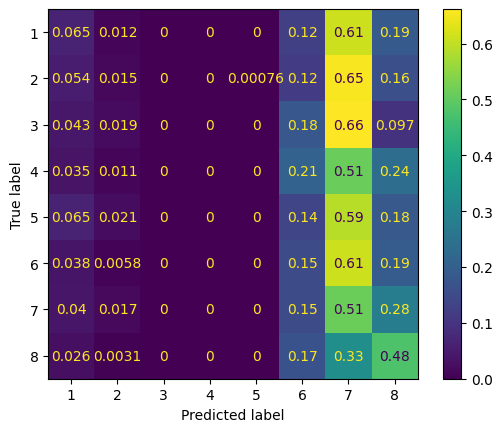

In [ ]:
#Se crea una matriz  de confusión para contrastar las predicciones que sabe hacer el modelo
#sobre los datos de train (X_train_scaled) contra los valores verdaderos asociados a los datos
#de train (y_train)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Se estima la matriz de confusión
matriz_confusion = confusion_matrix(y_tst, predicciones, normalize='true')

#Se grafica la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion, display_labels = np.array(['1', '2', '3', '4', '5', '6', '7', '8']))
disp.plot()
plt.show()

Se observa de los resultados obtenidos durante el entrenamiento y de lo mostrado en la matriz de confusión que el modelo de clasificación basado en ***redes neuronales*** no es bueno para esta tarea. Se observa en la ejecución del algoritmo de validación cruzada k-fold que el accuracy promedio logrado (la proporción de predicciones correctas sobre el total de predicciones) a lo sumo alcanza la cifra de 0,27 (27%) mientras que la matriz de confusión muestra que para toda la clasificación la tasa de verdaderos positivos (aquellos valores en la diagonal de la matriz) es en promedio del 16% y que incluso para algunas etiquetas es de 0%.

Se observa incluso que hay tasas de clasificaciones erróneas (aquellas fuera de la diagonal de la matriz) que bordean entre el 30% y el 50%, prediciendo incluso en exceso las etiquetas asociadas a los números 1 y 8. 

#Clasificación usando máquinas de vectores de soporte

In [ ]:
#Se parte de los datos ya normalizados que se usaron para la implementación del modelo basado en redes neuronales
#Se reestablece el vector de y_train pues este fue modificado en los pasos anteriores asociados a la implementación
#del modelo basado en redes neuronales
y_train = datos['Response']
#y_train = y_train.subtract(1)
#Se somete a análisis el modelo bajo un enfoque de k-fold cross-validation (validación cruzada de k iteraciones)
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import classification_report


#Se define un número de particiones para realizar cross-validation esa misma cantidad de veces
k = 5

#Se instancia KFold para contar con 5 iteraciones de la partición del conjunto de datos
kf = KFold(n_splits=k, shuffle=True)

#Se declara una lista vacía en la que se alojarán los accuracy promedio en cada corrida de la validación cruzada
accuracy_promedios = []

for train_index, test_index in kf.split(datos):
    X_tr, X_ts = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
    y_tr, y_ts = y_train.iloc[train_index], y_train.iloc[test_index]
    
    #Se crea un clasificador en cada una de estas iteraciones y se ajusta
    clasificador_svm = svm.LinearSVC(max_iter = 2000)
    clasificador_svm.fit(X_tr, y_tr)

    #Se usa el clasificador recién creado para predecir y así compararlo con los y_ts
    accuracy_promedios.append(clasificador_svm.score(X_ts, y_ts))

    #Se realizan predicciones con los datos de test X_ts y se comparan con los correspondientes y_ts
    y_pred = clasificador_svm.predict(X_ts)
    
    print(classification_report(y_ts,y_pred))
    

#print(accuracy_promedios)


              precision    recall  f1-score   support

           1       0.40      0.23      0.29      1224
           2       0.34      0.21      0.26      1252
           3       0.46      0.05      0.09       217
           4       0.45      0.70      0.54       269
           5       0.46      0.30      0.36      1139
           6       0.41      0.38      0.39      2264
           7       0.41      0.26      0.32      1604
           8       0.60      0.94      0.73      3908

    accuracy                           0.51     11877
   macro avg       0.44      0.38      0.37     11877
weighted avg       0.47      0.51      0.47     11877

              precision    recall  f1-score   support

           1       0.40      0.25      0.31      1236
           2       0.39      0.21      0.27      1395
           3       0.47      0.08      0.13       212
           4       0.47      0.63      0.54       280
           5       0.43      0.30      0.35      1000
           6       0.40 

In [ ]:
#Se estima el accuracy promedio obtenido con la clasificación usando máquinas de vectores de soporte SVC a través de la validación cruzada k-fold
from statistics import mean
accuracy_promedio_svc = mean(accuracy_promedios)
accuracy_promedio_svc

0.5047068451402331

In [ ]:
#Se hacen predicciones usando el modelo creado y los datos de test X_tst
predictions = clasificador_svm.predict(X_tst)
predicciones = pd.DataFrame(predictions)
predicciones

,0
0,2
1,8
2,5
3,4
4,8
...,...
11872,7
11873,1
11874,7
11875,4


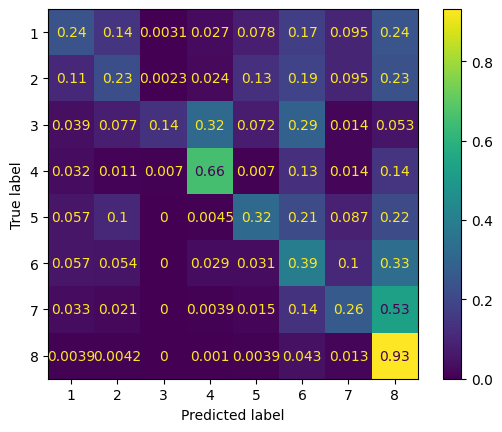

In [ ]:
#Se crea una matriz  de confusión para contrastar las predicciones que sabe hacer el modelo
#sobre los datos de train (X_train_scaled) contra los valores verdaderos asociados a los datos
#de train (y_train)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sn

#Se calcula la matriz de confusión
matriz_confusion = confusion_matrix(y_tst, predicciones, normalize='true')

#Se grafica la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion, display_labels = np.array(['1', '2', '3', '4', '5', '6', '7', '8']))
disp.plot()
plt.show()

Se observa de los resultados obtenidos durante el entrenamiento y de lo mostrado en la matriz de confusión que el modelo de clasificación basado en ***máquinas de vectores de soporte*** es mejor que el modelo de clasificación basado en ***redes neuronales*** sin embargo no se puede considerar bueno para esta tarea.

Se observa en la ejecución del algoritmo de validación cruzada k-fold que el accuracy promedio logrado (la proporción de predicciones correctas sobre el total de predicciones) alcanza la cifra de 0,5 (50%) mientras que la matriz de confusión muestra que para toda la clasificación la tasa de verdaderos positivos (aquellos valores en la diagonal de la matriz) alcanza máximo el 93% y que para algunos valores incluso es menor, rondando entre el 30% y el 40%, promediando un 39% como tasa de acierto.

Se observa que hay tasas de clasificaciones erróneas (aquellas fuera de la diagonal de la matriz) que bordean entre el 10% y el 53%

El *recall* y el *f1-score* obtenidos para las cinco iteraciones de uso de entrenamiento y predicción de este modelo basado en máquinas de vectores de soporte está en alrededor del 38%, inferiores a la mitad de la capacidad de predicción que uno esperaría de un modelo.

#Clasificación usando Random Forest

In [ ]:
#Para este clasificador no es necesario recurrir a datos normalizados.
#Se usarán los datos originales X_train, X_test, y_train
#Se reestablece el vector de y_train de manera preventiva pues este sufrió modificaciones en la clasificación usando redes neuronales
y_train = datos['Response']
#y_train = y_train.subtract(1)
#Se somete a análisis el modelo bajo un enfoque de k-fold cross-validation (validación cruzada de k iteraciones)
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


#Se define un número de particiones para realizar cross-validation esa misma cantidad de veces
k = 5

#Se instancia KFold para contar con 5 iteraciones de la partición del conjunto de datos
kf = KFold(n_splits=k, shuffle=True)

for train_index, test_index in kf.split(datos):
    X_tr, X_ts = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_ts = y_train.iloc[train_index], y_train.iloc[test_index]
    
    #Se crea un clasificador en cada una de estas iteraciones y se ajusta
    clasificador_rf = RandomForestClassifier(n_estimators=250)
    clasificador_rf.fit(X_tr, y_tr)

    #Se usa el clasificador recién creado para predecir y así compararlo con los y_ts
    y_pred = clasificador_rf.predict(X_ts)
    print(classification_report(y_ts,y_pred))
    #accuracy = accuracy_score(y_ts, y_pred)
    #accuracy_promedios.append(accuracy)
    #precision = precision_score(y_ts, y_pred)
    #precision_promedios.append(precision)
    #recall = recall_score(y_ts, y_pred)
    #recall_promedios.append(recall)

#print(accuracy_promedios)


In [ ]:
#Se estima el accuracy promedio obtenido con la clasificación usando máquinas de vectores de soporte SVC a través de la validación cruzada k-fold
#from statistics import mean
#accuracy_promedio_rf = mean(accuracy_promedios)
#precision_promedio_rf = mean(precision_promedios)
#recall_promedio_rf = mean(recall_promedios)
#print(f"{accuracy_promedio_rf} , {precision_promedio_rf} , {recall_promedio_rf}")

In [ ]:
from sklearn.model_selection import train_test_split
y_train = datos['Response']

SEED = 42
X_trn, X_tst, y_trn, y_tst = train_test_split(X_train, y_train, 
                                                    test_size=0.2, 
                                                    random_state=SEED)

In [ ]:
#Se usa el último modelo para predecir y así contrastar
predictions = clasificador_rf.predict(X_tst)
predicciones = pd.DataFrame(predictions)
predicciones

,0
0,7
1,8
2,2
3,4
4,6
...,...
11872,1
11873,1
11874,6
11875,4


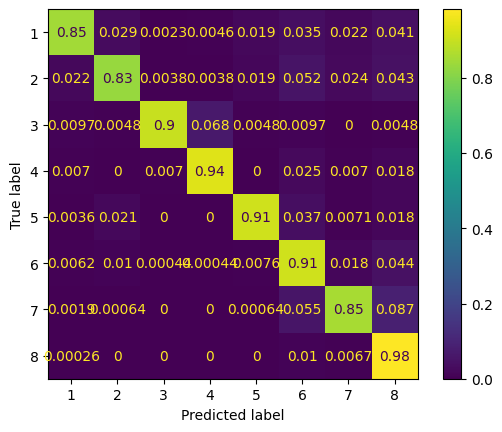

In [ ]:
#Se crea una matriz  de confusión para contrastar las predicciones que sabe hacer el modelo
#sobre los datos de train (X_train_scaled) contra los valores verdaderos asociados a los datos
#de train (y_train)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Se calcula la matriz de confusión
matriz_confusion = confusion_matrix(y_tst, predicciones, normalize='true')

#Se grafica la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion, display_labels = np.array(['1', '2', '3', '4', '5', '6', '7', '8']))
disp.plot()
plt.show()

Se observa de los resultados obtenidos durante el entrenamiento y de lo mostrado en la matriz de confusión que el modelo de clasificación basado en ***random forest*** es mejor que el modelo de clasificación basado en ***redes neuronales*** y en ***máquinas de vectores de soporte*** sin embargo el accuracy promedio obtenido no se puede considerar satisfactorio (58%)

Se observa en la ejecución del algoritmo de validación cruzada k-fold que el accuracy promedio logrado (la proporción de predicciones correctas sobre el total de predicciones) alcanza la cifra de 0,58 (58%) mientras que la matriz de confusión muestra que para toda la clasificación la tasa de verdaderos positivos (aquellos valores en la diagonal de la matriz) alcanza máximo el 98%, oscilando entre el 85% y el 98%  y promediando un 90% como tasa de acierto.

Se observa que hay tasas de clasificaciones erróneas (aquellas fuera de la diagonal de la matriz) que bordean entre el 5% y el 7%. El *recall* y el *f1-score* obtenidos para las cinco iteraciones de uso de entrenamiento y predicción de este modelo basado en ***random forest*** está en alrededor del 50%, superiores a los obtenidos con ***redes neuronales*** y con ***máquinas de vectores de soporte*** pero de apenas la mitad de la capacidad de predicción que uno esperaría de un modelo.

#Clasificación usando regresión logística

In [ ]:
#Se usarán los datos normaizados X_train_scaled
#Se reestablece el vector de y_train de manera preventiva pues este sufrió modificaciones
y_train = datos['Response']
#y_train = y_train.subtract(1)
#Se somete a análisis el modelo bajo un enfoque de k-fold cross-validation (validación cruzada de k iteraciones)
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


#Se define un número de particiones para realizar cross-validation esa misma cantidad de veces
k = 5

#Se instancia KFold para contar con 5 iteraciones de la partición del conjunto de datos
kf = KFold(n_splits=k, shuffle=True)

for train_index, test_index in kf.split(datos):
    X_tr, X_ts = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
    y_tr, y_ts = y_train.iloc[train_index], y_train.iloc[test_index]
    
    #Se crea un clasificador en cada una de estas iteraciones y se ajusta
    clasificador_rl = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    clasificador_rl.fit(X_tr, y_tr)

    #Se usa el clasificador recién creado para predecir y así compararlo con los y_ts
    y_pred = clasificador_rl.predict(X_ts)
    print(classification_report(y_ts,y_pred))
    #accuracy = accuracy_score(y_ts, y_pred)
    #accuracy_promedios.append(accuracy)
    #precision = precision_score(y_ts, y_pred)
    #precision_promedios.append(precision)
    #recall = recall_score(y_ts, y_pred)
    #recall_promedios.append(recall)

#print(accuracy_promedios)

              precision    recall  f1-score   support

           1       0.40      0.26      0.32      1247
           2       0.37      0.26      0.31      1307
           3       0.43      0.38      0.41       200
           4       0.49      0.60      0.54       281
           5       0.50      0.34      0.41      1114
           6       0.41      0.43      0.42      2216
           7       0.42      0.26      0.32      1595
           8       0.64      0.91      0.75      3917

    accuracy                           0.52     11877
   macro avg       0.46      0.43      0.43     11877
weighted avg       0.49      0.52      0.49     11877

              precision    recall  f1-score   support

           1       0.39      0.26      0.31      1244
           2       0.32      0.23      0.27      1306
           3       0.46      0.40      0.43       218
           4       0.51      0.62      0.56       289
           5       0.49      0.31      0.38      1127
           6       0.43 

In [ ]:
from sklearn.model_selection import train_test_split
y_train = datos['Response']

SEED = 42
X_trn, X_tst, y_trn, y_tst = train_test_split(X_train_scaled, y_train, 
                                                    test_size=0.2, 
                                                    random_state=SEED)

In [ ]:
#Se usa el último modelo para predecir y así contrastar
predictions = clasificador_rl.predict(X_tst)
predicciones = pd.DataFrame(predictions)
predicciones

,0
0,2
1,8
2,5
3,4
4,6
...,...
11872,7
11873,1
11874,7
11875,4


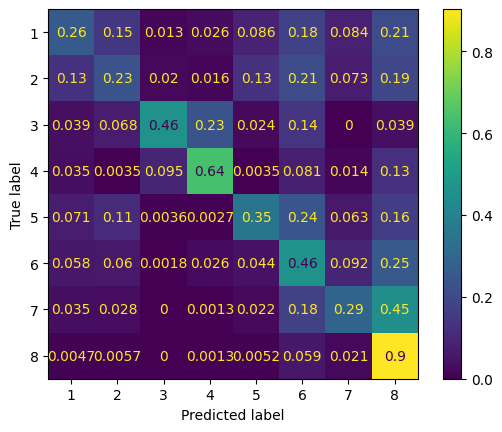

In [ ]:
#Se crea una matriz  de confusión para contrastar las predicciones que sabe hacer el modelo
#sobre los datos de train (X_train_scaled) contra los valores verdaderos asociados a los datos
#de test (y_tst)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Se calcula la matriz de confusión
matriz_confusion = confusion_matrix(y_tst, predicciones, normalize='true')

#Se grafica la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion, display_labels = np.array(['1', '2', '3', '4', '5', '6', '7', '8']))
disp.plot()
plt.show()

Se observa de los resultados obtenidos durante el entrenamiento y de lo mostrado en la matriz de confusión que el modelo de clasificación basado en ***regresión logística*** se parece en desempeño al modelo basado en ***máquinas de vectores de soporte*** pero con un *recall* y un *f1-score* ligeramente superiores.

Se observa en la ejecución del algoritmo de validación cruzada k-fold que el accuracy promedio logrado (la proporción de predicciones correctas sobre el total de predicciones) alcanza la cifra de 0,5 (50%) mientras que la matriz de confusión muestra que para toda la clasificación la tasa de verdaderos positivos (aquellos valores en la diagonal de la matriz) alcanza máximo el 93% y que para algunos valores incluso es menor, rondando entre el 30% y el 40%, promediando un 45% como tasa de acierto.

Se observa que hay tasas de clasificaciones erróneas (aquellas fuera de la diagonal de la matriz) que bordean entre el 10% y el 53%

El *recall* y el *f1-score* obtenidos para las cinco iteraciones de uso de entrenamiento y predicción de este modelo basado en máquinas de vectores de soporte está en alrededor del 44%, inferiores a la mitad de la capacidad de predicción que uno esperaría de un modelo.

#Conclusiones


*   Ninguno de los modelos ensayados ha mostrado un desempeño bueno. Las tasas de *accuracy* observadas se encuentran entre el 27% (***redes neuronales***) y el 50% (***random forest***) mientras que las tasas de *recall* y *f1-score* observadas se encuentran entre el 38% (***máquinas de vectores de soporte***) y el 50% (***random forest***)
*   De los cuatro modelos ensayados, el modelo de mejor desempeño es ***random forest*** y el modelo de desempeño más bajo es el basado en ***redes neuronales***



#Aplicación de PCA para manejar un conjunto de datos de dimensiones reducidas

Se busca aplicar PCA con distintos componentes para verificar el desempeño de los modelos ante un conjunto de datos de menos dimensiones. No se va a implementar validación cruzada como en los casos anteriores sino que con una única partición se entrenarán y validarán los cuatro modelos obtenidos.

In [ ]:
from sklearn.decomposition import PCA                 #Para la reducción de las dimensiones del conjunto de datos en componentes principales
import tensorflow as tf                               #Para crear un modelo basado en redes neuronales
from sklearn import svm                               #Para crear un modelo basado en máquinas de vectores de soporte
from sklearn.ensemble import RandomForestClassifier   #Para crear un modelo basado en clasificador Random Forest
from sklearn.linear_model import LogisticRegression   #Para crear un modelo basado en regresión logística
from sklearn.model_selection import train_test_split  #Para dividir el conjunto de datos en train y test
from sklearn.metrics import accuracy_score            #Para estimar el accuracy de los demás modelos directamente con SciKit-Learn

X = X_train_scaled                                    #Se trae como X a X_train_scaled obtenido anteriormente, el cuál es el X original pero estandarizado
y = datos['Response']                                 #Se trae como y a la columna "Response" del conjunto de datos original
y_rn = y.subtract(1)                                  #Se reta una unidad a cada dato de la columna "Response" para evitar un error en el uso de redes neuronales

lista_caracteristicas = [16, 48, 80, 112, X.shape[1], 'Sin reducción']
lista_accuracies = []
dicc_desempenhos = {}
dicc_desempenhos['Modelo'] = ['Redes Neuronales', 'SVM', 'Random Forest', 'Regresión Logística']
h1 = np.random.randint(5)+5                           #Cantidad de neuronas en la primera capa oculta de la red neuronal
h2 = np.random.randint(5)+5                           #Cantidad de neuronas en la segunda capa oculta de la red neuronal

for num_car in lista_caracteristicas:

  if num_car != 'Sin reducción':
    #Se transforman los datos a menos características
    pca = PCA(n_components = num_car)
    Xpca = pca.fit_transform(X)
  
  elif num_car == 'Sin reducción':
    Xpca = X
  
  #Se particiona el nuevo conjunto de datos donde X tiene dimensiones reducidas
  SEED = 42
  Xpca_trn, Xpca_tst, y_trn, y_tst = train_test_split(Xpca, y, test_size=0.2, random_state=SEED)

  #Se particiona el nuevo conjunto de datos donde X tiene dimensiones reducidas SOLO PARA REDES NEURONALES PUES y_rn ACÁ TIENE RESTADO UN 1
  SEED = 42
  XpcaNN_trn, XpcaNN_tst, yNN_trn, yNN_tst = train_test_split(Xpca, y_rn, test_size=0.2, random_state=SEED)

  #Se entrenan cuatro modelos con el nuevo conjunto de datos: Redes neuronales, SVM, random forest y regresión logística
  #Redes neuronales:

  n = Xpca.shape[1]                                       #El tamaño del modelo basado en redes neuronales debe corresponder a la dimensión del espacio de características
  model = tf.keras.Sequential(
        [
         tf.keras.layers.Dense(h1, activation='tanh', dtype=tf.float32),
         tf.keras.layers.Dense(h2, activation='tanh', dtype=tf.float32),
         tf.keras.layers.Dense(8, activation='sigmoid', dtype=tf.float32)
        ]
         )
  model.build(input_shape=[None, n])
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = .5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.fit(XpcaNN_trn, yNN_trn, epochs = 3, batch_size = 1)
  dicc_eval_RN = model.get_metrics_result()
  acc_RN = dicc_eval_RN['accuracy']
  print(acc_RN.numpy())
  print(h1)
  print(h2)
  lista_accuracies.append(acc_RN.numpy())

  #Máquinas de vectores de soporte:
  clasificador_svm = svm.LinearSVC(max_iter = 2000)
  clasificador_svm.fit(Xpca_trn, y_trn)
  acc_SVM = clasificador_svm.score(Xpca_tst, y_tst)
  lista_accuracies.append(acc_SVM)

  #Random Forest:
  clasificador_rf = RandomForestClassifier(n_estimators=250)
  clasificador_rf.fit(Xpca_trn, y_trn)
  acc_RF = clasificador_rf.score(Xpca_tst, y_tst)
  lista_accuracies.append(acc_RF)

  #Regresión logística:
  clasificador_rl = LogisticRegression(solver='lbfgs', multi_class='multinomial')
  clasificador_rl.fit(Xpca_trn, y_trn)
  acc_RL = clasificador_rl.score(Xpca_tst, y_tst)
  lista_accuracies.append(acc_RL)

  #Se consigna el resultado en el diccionario
  dicc_desempenhos[num_car] = lista_accuracies

  #Se resetea la lista para la próxima iteración
  lista_accuracies = []

Epoch 1/3
47504/47504 [==============================] - 86s 2ms/step - loss: 2.5778 - accuracy: 0.2580
Epoch 2/3
47504/47504 [==============================] - 81s 2ms/step - loss: 2.5792 - accuracy: 0.2655
Epoch 3/3
47504/47504 [==============================] - 79s 2ms/step - loss: 2.6124 - accuracy: 0.2557
0.25568372
8
5
Epoch 1/3
47504/47504 [==============================] - 82s 2ms/step - loss: 2.6244 - accuracy: 0.2446
Epoch 2/3
47504/47504 [==============================] - 81s 2ms/step - loss: 2.6006 - accuracy: 0.2560
Epoch 3/3
47504/47504 [==============================] - 78s 2ms/step - loss: 2.6187 - accuracy: 0.2505
0.25054732
8
5
Epoch 1/3
47504/47504 [==============================] - 84s 2ms/step - loss: 2.5929 - accuracy: 0.2539
Epoch 2/3
47504/47504 [==============================] - 82s 2ms/step - loss: 2.5757 - accuracy: 0.2672
Epoch 3/3
47504/47504 [==============================] - 80s 2ms/step - loss: 2.6285 - accuracy: 0.2483
0.24833699
8
5
Epoch 1/3
47504/475

In [ ]:
#print(dicc_desempenhos)
pd.DataFrame.from_dict(dicc_desempenhos)

,Modelo,16,48,80,112,144,Sin reducción
0,Redes Neuronales,0.255684,0.250547,0.248337,0.249853,0.261494,0.254779
1,SVM,0.416604,0.447756,0.466616,0.499032,0.503999,0.504505
2,Random Forest,0.449188,0.463669,0.464848,0.478909,0.479077,0.572114
3,Regresión Logística,0.428896,0.462491,0.487497,0.520333,0.523028,0.523028


#Conclusiones
Se observa que los modelos, a pesar de ser procesados  con transformaciones de reducción de dimensionalidad, no logran incrementar el accuracy en su desempeño. Se observa que para este problema de clasificación  hay modelos de desempeño inferior como lo es el modelo basado en ***redes neuronales***.  Los demás  modelos se desempeñan más o menos igual, destacándose ligeramente entre ellos el modelo basado en ***random forest***, seguido del modelo basado en ***regresión logística***.

De las compilaciones y computaciones realizadas el equipo de trabajo notó que el modelo basado en ***máquinas de vectores de soporte*** es muy costoso computacionalmente (toma mucho tiempo su ejecución) por lo que se considera que en ese aspecto también es inferior a los modelos basados en ***random forest*** y en ***regresión logística***, que también es un modelo de clasificación binaria.

Entra en cuestión la calidad del conjunto de datos y la calidad del preprocesado, particularmente el método de llenado de datos vacíos, entre otras cuestiones.